In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install h5py

In [ ]:
import os
from tqdm import tqdm
from google.colab import files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageEnhance

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D,
    concatenate, BatchNormalization, Activation, LeakyReLU
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dense, Conv2DTranspose, UpSampling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, UpSampling2D, Dropout

from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import h5py

In [ ]:
import h5py

# Caminho para o arquivo HDF5 no Google Drive
file_path = '/content/drive/MyDrive/PROJETO/g5_dataset_augmented_processed_28_ago.h5'

# Carregando os arrays do arquivo HDF5
with h5py.File(file_path, 'r') as h5f:
    X_train_processed = h5f['x_train'][:]
    X_test_processed = h5f['x_test'][:]
    y_train_reduced = h5f['y_train'][:]
    y_test_reduced = h5f['y_test'][:]

In [ ]:
X_train_processed.shape, X_test_processed.shape, y_train_reduced.shape, y_test_reduced.shape

((9570, 128, 128, 3),
 (798, 128, 128, 3),
 (9570, 128, 128, 3),
 (798, 128, 128, 3))

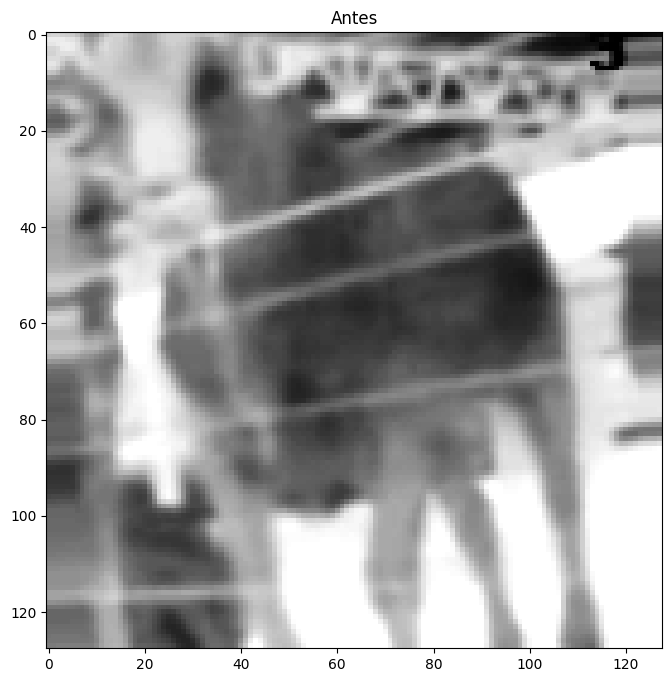

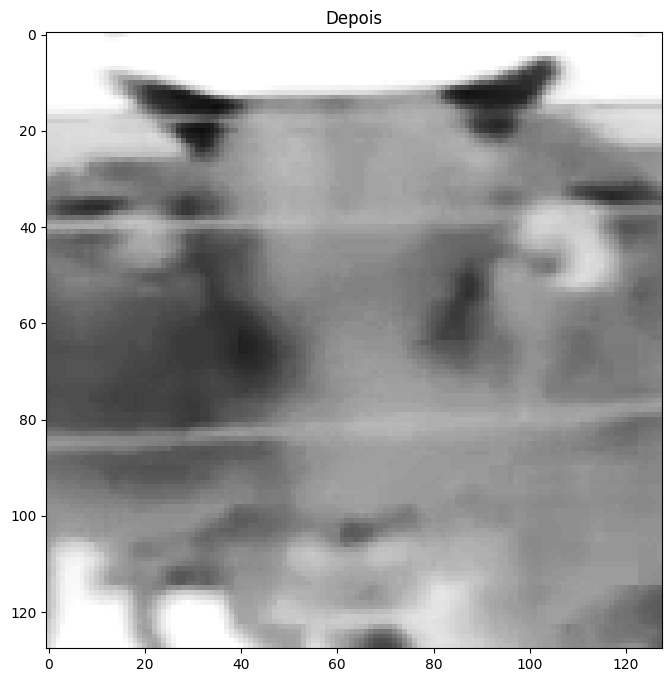

In [ ]:
random_index = np.random.randint(0, X_test_processed.shape[0])

image = X_train_processed[random_index]
image2= X_test_processed[random_index]

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f'Antes')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(image2)
plt.title(f'Depois')
plt.show()

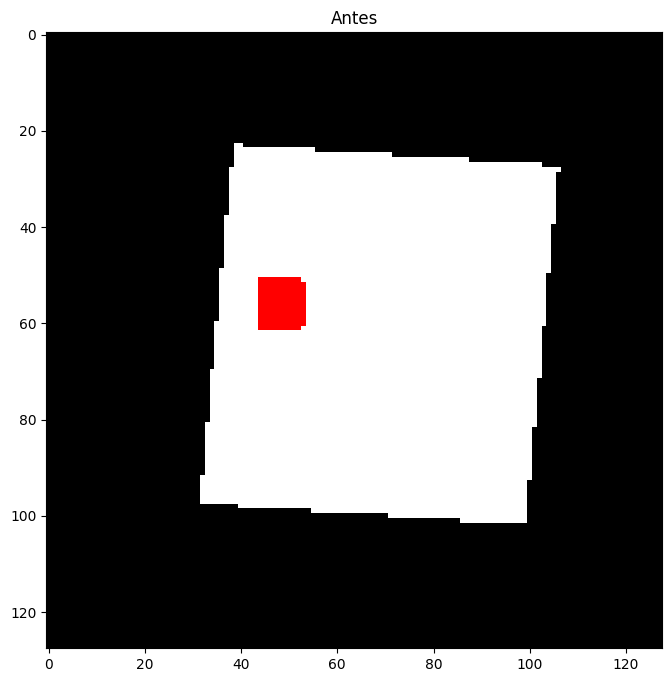

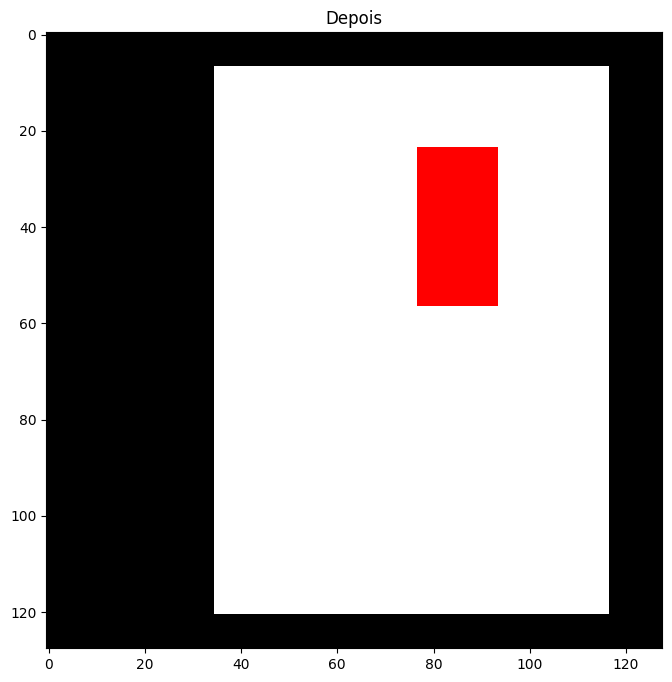

In [ ]:
random_index = np.random.randint(0, y_test_reduced.shape[0])

image = y_train_reduced[random_index]
image2= y_test_reduced[random_index]

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f'Antes')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(image2)
plt.title(f'Depois')
plt.show()

In [ ]:
import numpy as np

def reduce_to_single_channel(image):
    # Cria uma matriz de zeros com as mesmas dimensões da imagem, mas com apenas um canal
    result = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

    # Define as cores
    white = np.array([1.0, 1.0, 1.0])
    red = np.array([1.0, 0.0, 0.0])
    black = np.array([0.0, 0.0, 0.0])

    # Compara cada pixel com as cores definidas
    result[(image == white).all(axis=2)] = 0  # Branco
    result[(image == black).all(axis=2)] = 1  # Preto
    result[(image == red).all(axis=2)] = 2    # Vermelho

    return result

def reduce_colors_dataset_to_single_channel(dataset):
    # Cria um novo array para armazenar os resultados
    result = np.zeros((dataset.shape[0], dataset.shape[1], dataset.shape[2]), dtype=np.uint8)

    # Aplica a função reduce_to_single_channel para cada imagem no dataset
    for i in range(dataset.shape[0]):
        result[i] = reduce_to_single_channel(dataset[i])

    return result

# Aplicar a função ao y_train e y_test
y_train_single_channel = reduce_colors_dataset_to_single_channel(y_train_reduced)
y_test_single_channel = reduce_colors_dataset_to_single_channel(y_test_reduced)

# Verificar o shape do resultado
print("Shape of y_train_single_channel:", y_train_single_channel.shape)
print("Shape of y_test_single_channel:", y_test_single_channel.shape)

# Verificar os valores únicos para garantir que temos apenas 0, 1 e 2
print("Unique values in y_train_single_channel:", np.unique(y_train_single_channel))
print("Unique values in y_test_single_channel:", np.unique(y_test_single_channel))

Shape of y_train_single_channel: (9570, 128, 128)
Shape of y_test_single_channel: (798, 128, 128)
Unique values in y_train_single_channel: [0 1]
Unique values in y_test_single_channel: [0 1]


In [ ]:
val_split = 0.2
val_samples = int(len(X_train_processed) * val_split)
X_train_vgg16, y_train_vgg16 = X_train_processed[:-val_samples], y_train_single_channel[:-val_samples]
X_val_vgg16, y_val_vgg16 = X_train_processed[-val_samples:], y_train_single_channel[-val_samples:]

In [ ]:
X_train_vgg16.shape, y_train_vgg16.shape, X_val_vgg16.shape, y_val_vgg16.shape

((7656, 128, 128, 3), (7656, 128, 128), (1914, 128, 128, 3), (1914, 128, 128))

**MODELO 1 PEQUENO**

In [ ]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [ ]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense

vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

modelo_novo = Sequential()

for layer in vgg.layers[:8]:
    modelo_novo.add(layer)
    layer.trainable = False

modelo_novo.add(UpSampling2D(size=(4, 4)))  # (64, 64, 256)
modelo_novo.add(Conv2D(32, (3, 3), padding='same'))
modelo_novo.add(LeakyReLU(alpha=0.1))

# Camada de saída com 3 filtros (um para cada classe) e ativação softmax
modelo_novo.add(Conv2D(3, (1, 1), activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
modelo_novo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 128, 128, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │          73,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 3)         │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 629,187 (2.40 MB)

 Trainable params: 73,859 (288.51 KB)

 Non-trainable params: 555,328 (2.12 MB)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def categorical_dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f, axis=-1)
    return (2. * intersection + smooth) / (K.sum(y_true_f, axis=-1) + K.sum(y_pred_f, axis=-1) + smooth)

def categorical_dice_loss(y_true, y_pred):
    return 1 - categorical_dice_coef(y_true, y_pred)

def categorical_focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * K.log(y_pred)
    focal_loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(K.sum(focal_loss, axis=-1))

def categorical_iou_score(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
    union = K.sum(y_true, [1,2]) + K.sum(y_pred, [1,2]) - intersection
    return K.mean((intersection + smooth) / (union + smooth), axis=-1)

def categorical_iou_focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0, iou_weight=0.7):
    iou_loss = 1 - categorical_iou_score(y_true, y_pred)
    focal_loss = categorical_focal_loss(y_true, y_pred, alpha, gamma)
    return iou_weight * iou_loss + (1 - iou_weight) * focal_loss

# Compile the model
modelo_novo.compile(optimizer='adam',
                    loss=categorical_iou_focal_loss,
                    metrics=[categorical_iou_focal_loss, 'categorical_crossentropy'])

# Callbacks
checkpoint = ModelCheckpoint('VGG_multiclass_pixel_classification.keras',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=1e-5)

# Convert labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train_vgg16, num_classes=3)
y_val_onehot = tf.keras.utils.to_categorical(y_val_vgg16, num_classes=3)

# Train the model
history = modelo_novo.fit(
    X_train_vgg16,
    y_train_onehot,
    validation_data=(X_val_vgg16, y_val_onehot),
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions(X_test, y_test, modelo_novo, num_samples=5):
    # Escolha aleatória de amostras
    samples = np.random.choice(len(X_test), num_samples, replace=False)

    # Faça predições
    y_pred = modelo_novo.predict(X_test[samples])

    # Converta as predições para classes
    y_pred_classes = np.argmax(y_pred, axis=-1)

    # Crie um mapa de cores personalizado
    color_map = plt.cm.colors.ListedColormap(['white', 'black', 'red'])

    # Configuração do plot
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for i, sample in enumerate(samples):
        # Imagem de entrada
        axes[i, 0].imshow(X_test[sample])
        axes[i, 0].set_title('Imagem de Entrada')
        axes[i, 0].axis('off')

        # Ground Truth
        axes[i, 1].imshow(y_test[sample], cmap=color_map, vmin=0, vmax=2)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        # Predição
        axes[i, 2].imshow(y_pred_classes[i], cmap=color_map, vmin=0, vmax=2)
        axes[i, 2].set_title('Predição')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Uso da função
visualize_predictions(X_test, y_test, modelo_novo)

**MODELO 2**

In [ ]:
vgg2 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg2.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense

vgg2 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

modelo_novo = Sequential()

for layer in vgg2.layers[:11]:
    modelo_novo.add(layer)
    layer.trainable = False

modelo_novo.add(UpSampling2D(size=(2, 2)))  # (64, 64, 256)
modelo_novo.add(Conv2D(64, (3, 3), padding='same'))
modelo_novo.add(LeakyReLU(alpha=0.1))

modelo_novo.add(UpSampling2D(size=(2, 2)))  # (64, 64, 256)
modelo_novo.add(Conv2D(32, (3, 3), padding='same'))
modelo_novo.add(LeakyReLU(alpha=0.1))

modelo_novo.add(UpSampling2D(size=(2, 2)))  # (64, 64, 256)
modelo_novo.add(Conv2D(16, (3, 3), padding='same'))
modelo_novo.add(LeakyReLU(alpha=0.1))

# Camada de saída com 3 filtros (um para cada classe) e ativação softmax
modelo_novo.add(Conv2D(3, (1, 1), activation='softmax'))

modelo_novo.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_8 (UpSampling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 64)          │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_9 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_10 (UpSampling2D)      │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 128, 128, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 128, 128, 3)         │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,906,147 (7.27 MB)

 Trainable params: 170,659 (666.64 KB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def categorical_dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f, axis=-1)
    return (2. * intersection + smooth) / (K.sum(y_true_f, axis=-1) + K.sum(y_pred_f, axis=-1) + smooth)

def categorical_dice_loss(y_true, y_pred):
    return 1 - categorical_dice_coef(y_true, y_pred)

def categorical_focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * K.log(y_pred)
    focal_loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(K.sum(focal_loss, axis=-1))

def categorical_iou_score(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
    union = K.sum(y_true, [1,2]) + K.sum(y_pred, [1,2]) - intersection
    return K.mean((intersection + smooth) / (union + smooth), axis=-1)

def categorical_iou_focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0, iou_weight=0.7):
    iou_loss = 1 - categorical_iou_score(y_true, y_pred)
    focal_loss = categorical_focal_loss(y_true, y_pred, alpha, gamma)
    return iou_weight * iou_loss + (1 - iou_weight) * focal_loss

# Compile the model
modelo_novo.compile(optimizer='adam',
                    loss=categorical_iou_focal_loss,
                    metrics=[categorical_iou_focal_loss, 'categorical_crossentropy'])

# Callbacks
checkpoint = ModelCheckpoint('VGG_multiclass_pixel_classification.keras',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=1e-5)

# Convert labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train_vgg16, num_classes=3)
y_val_onehot = tf.keras.utils.to_categorical(y_val_vgg16, num_classes=3)

# Train the model
history = modelo_novo.fit(
    X_train_vgg16,
    y_train_onehot,
    validation_data=(X_val_vgg16, y_val_onehot),
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions(X_test, y_test, modelo_novo, num_samples=5):
    # Escolha aleatória de amostras
    samples = np.random.choice(len(X_test), num_samples, replace=False)

    # Faça predições
    y_pred = modelo_novo.predict(X_test[samples])

    # Converta as predições para classes
    y_pred_classes = np.argmax(y_pred, axis=-1)

    # Crie um mapa de cores personalizado
    color_map = plt.cm.colors.ListedColormap(['white', 'black', 'red'])

    # Configuração do plot
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for i, sample in enumerate(samples):
        # Imagem de entrada
        axes[i, 0].imshow(X_test[sample])
        axes[i, 0].set_title('Imagem de Entrada')
        axes[i, 0].axis('off')

        # Ground Truth
        axes[i, 1].imshow(y_test[sample], cmap=color_map, vmin=0, vmax=2)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        # Predição
        axes[i, 2].imshow(y_pred_classes[i], cmap=color_map, vmin=0, vmax=2)
        axes[i, 2].set_title('Predição')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Uso da função
visualize_predictions(X_test, y_test, modelo_novo)

**MODELO 3**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense

vgg2 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

modelo_novo = Sequential()

for layer in vgg2.layers[:16]:
    modelo_novo.add(layer)
    layer.trainable = False

modelo_novo.add(UpSampling2D(size=(2, 2)))
modelo_novo.add(Conv2D(256, (3, 3), padding='same'))
modelo_novo.add(LeakyReLU(alpha=0.1))

modelo_novo.add(UpSampling2D(size=(2, 2)))
modelo_novo.add(Conv2D(128, (3, 3), padding='same'))
modelo_novo.add(LeakyReLU(alpha=0.1))

modelo_novo.add(UpSampling2D(size=(2, 2)))
modelo_novo.add(Conv2D(64, (3, 3), padding='same'))
modelo_novo.add(LeakyReLU(alpha=0.1))

modelo_novo.add(UpSampling2D(size=(2, 2)))
modelo_novo.add(Conv2D(32, (3, 3), padding='same'))
modelo_novo.add(LeakyReLU(alpha=0.1))
modelo_novo.add(Dropout(0.2))

modelo_novo.add(Conv2D(3, (1, 1), activation='softmax'))

modelo_novo.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_27 (UpSampling2D)      │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 16, 16, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_25 (LeakyReLU)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_28 (UpSampling2D)      │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_26 (LeakyReLU)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 11,562,371 (44.11 MB)

 Trainable params: 1,567,299 (5.98 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def categorical_dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f, axis=-1)
    return (2. * intersection + smooth) / (K.sum(y_true_f, axis=-1) + K.sum(y_pred_f, axis=-1) + smooth)

def categorical_dice_loss(y_true, y_pred):
    return 1 - categorical_dice_coef(y_true, y_pred)

def categorical_focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * K.log(y_pred)
    focal_loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(K.sum(focal_loss, axis=-1))

def categorical_iou_score(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
    union = K.sum(y_true, [1,2]) + K.sum(y_pred, [1,2]) - intersection
    return K.mean((intersection + smooth) / (union + smooth), axis=-1)

def categorical_iou_focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0, iou_weight=0.7):
    iou_loss = 1 - categorical_iou_score(y_true, y_pred)
    focal_loss = categorical_focal_loss(y_true, y_pred, alpha, gamma)
    return iou_weight * iou_loss + (1 - iou_weight) * focal_loss

# Compile the model
modelo_novo.compile(optimizer='adam',
                    loss=categorical_iou_focal_loss,
                    metrics=[categorical_iou_focal_loss, 'categorical_crossentropy'])

# Callbacks
checkpoint = ModelCheckpoint('VGG_multiclass_pixel_classification.keras',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=1e-5)

# Convert labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train_vgg16, num_classes=3)
y_val_onehot = tf.keras.utils.to_categorical(y_val_vgg16, num_classes=3)

# Train the model
history = modelo_novo.fit(
    X_train_vgg16,
    y_train_onehot,
    validation_data=(X_val_vgg16, y_val_onehot),
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions(X_test, y_test, modelo_novo, num_samples=5):
    # Escolha aleatória de amostras
    samples = np.random.choice(len(X_test), num_samples, replace=False)

    # Faça predições
    y_pred = modelo_novo.predict(X_test[samples])

    # Converta as predições para classes
    y_pred_classes = np.argmax(y_pred, axis=-1)

    # Crie um mapa de cores personalizado
    color_map = plt.cm.colors.ListedColormap(['white', 'black', 'red'])

    # Configuração do plot
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for i, sample in enumerate(samples):
        # Imagem de entrada
        axes[i, 0].imshow(X_test[sample])
        axes[i, 0].set_title('Imagem de Entrada')
        axes[i, 0].axis('off')

        # Ground Truth
        axes[i, 1].imshow(y_test[sample], cmap=color_map, vmin=0, vmax=2)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        # Predição
        axes[i, 2].imshow(y_pred_classes[i], cmap=color_map, vmin=0, vmax=2)
        axes[i, 2].set_title('Predição')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Uso da função
visualize_predictions(X_test, y_test, modelo_novo)